In [1]:
import os
import sys
from pathlib import Path
from torch.nn import DataParallel
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import itertools

pv_vision_dir = os.path.join(Path.home(), "pv-vision")
functions_dir = os.path.join(Path.home(), "el_img_cracks_ec")
sys.path.append(pv_vision_dir)
sys.path.append(functions_dir)

ojas_functions_dir = os.path.join(Path.home(), "pvcracks/retrain/")
sys.path.append(ojas_functions_dir)

from tutorials.unet_model import construct_unet
import functions

In [2]:
def load_dataset(root):
    transformers = functions.Compose(
        [functions.FixResize(256), functions.ToTensor(), functions.Normalize()]
    )

    val_dataset = functions.SolarDataset(
        root, image_folder="img/val", mask_folder="ann/val", transforms=transformers
    )

    return val_dataset

In [3]:
def load_device_and_model(weight_path):
    device = torch.device("mps")
    unet = construct_unet(5)
    unet = torch.nn.DataParallel(unet)

    checkpoint = torch.load(weight_path, map_location=device)
    from collections import OrderedDict

    new_state_dict = OrderedDict()
    for k, v in checkpoint.items():
        name = "module." + k
        new_state_dict[name] = v

    unet.load_state_dict(new_state_dict)

    model = unet.module.to(device)

    return device, model

In [4]:
def show(mask, raw_img, test_res, layers_to_render=None):
    mask_cpu = mask.cpu().numpy()

    cmap = mpl.colormaps["viridis"].resampled(5)  # define the colormap
    cmaplist = [cmap(i) for i in range(5)]

    fig, ax = plt.subplots(ncols=3, figsize=(12, 12), layout="compressed")
    # fig, ax = plt.subplots(ncols=2, figsize=(12,6), layout='compressed')

    im = ax[0].imshow(raw_img.convert("L"), cmap="gray", interpolation="None")
    ax[0].axis("off")

    # clim = (0, 4)
    im = ax[1].imshow(
        mask_cpu,
        cmap="viridis",
        # clim=clim,
    )
    ax[1].axis("off")
    ax[1].set_title("Ground Truth Mask")

    if layers_to_render is not None:
        test_res = np.where(np.isin(test_res, layers_to_render), test_res, 0)

    ax[2].imshow(
        test_res, cmap="viridis", interpolation="None"
    )  # clim=clim, interpolation="None")
    handles, labels = ax[2].get_legend_handles_labels()

    for c, classlabel in zip(
        cmaplist, [f"({k}) {v}" for k, v in category_mapping.items()]
    ):
        patch = mpatches.Patch(color=c, label=classlabel, ec="k")
        handles.append(patch)
    ax[2].legend(handles=handles, fontsize="x-small")
    ax[2].axis("off")
    ax[2].set_title("Retrained Model Prediction")

In [5]:
def inference_and_show(idx, root, weight_path, layers_to_render=None):
    val_dataset = load_dataset(root)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    device, model = load_device_and_model(weight_path)

    img, mask = val_loader.dataset.__getitem__(idx)
    img = img.to(device)
    raw_img, _ = val_loader.dataset.__getraw__(idx)
    test_res = model(img.unsqueeze(0)).detach().cpu().numpy().squeeze()
    test_res = np.argmax(test_res, axis=0)

    show(mask, raw_img, test_res, layers_to_render=layers_to_render)

/var/folders/_l/7n7n98ws5fx8zfcbxfmfs7fh0000gn/T/ipykernel_49478/41691919.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weight_path, map_locati

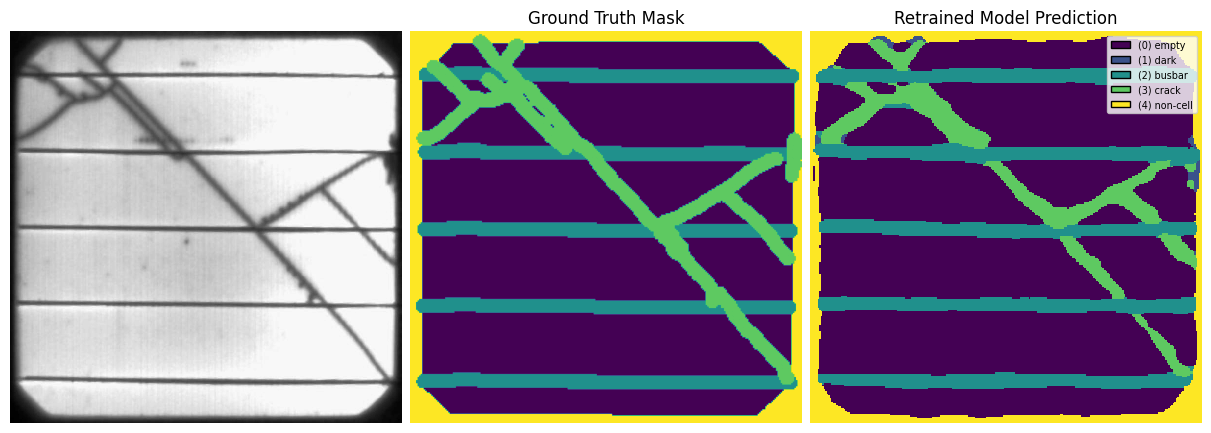

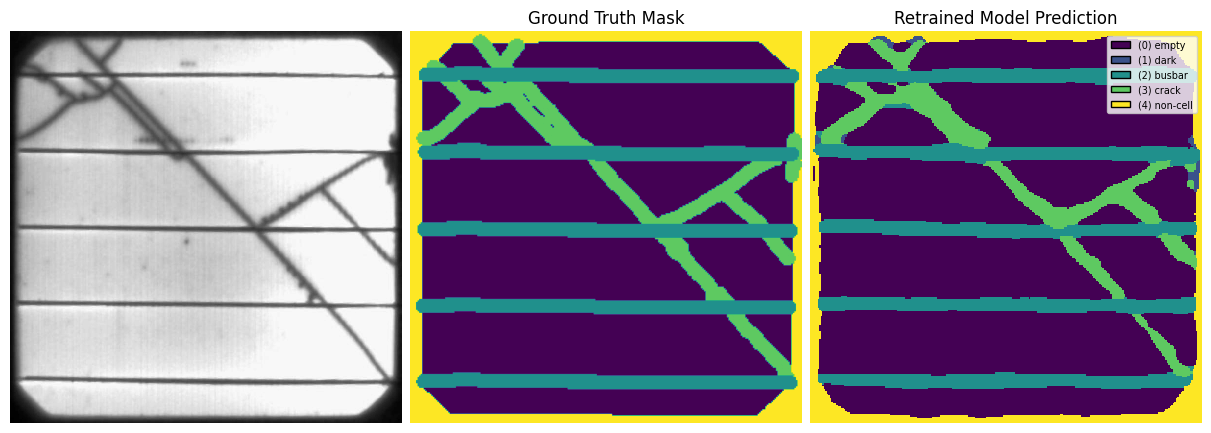

In [6]:
category_mapping = {0: "empty", 1: "dark", 2: "busbar", 3: "crack", 4: "non-cell"}
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_LBNL_ASU/"
# weight_path = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_LBNL_ASU/checkpoints/Combined_CWRU_LBNL_ASU3/epoch_30/Combined_CWRU_LBNL_ASU.pt"

# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_ASU/"
# weight_path = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_ASU/checkpoints/Combined_CWRU_ASU1/epoch_30/Combined_CWRU_ASU.pt"

root = (
    "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_ASU_ContinuousCracks/"
)
weight_path = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_ASU_ContinuousCracks/checkpoints/Combined_CWRU_ASU_ContinuousCracks1/epoch_30/model.pt"


batch_size = 1
layers_to_render = None

ann_dir = os.path.join(root, "ann/val")

val_dataset = load_dataset(root)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

cr_name = "cr_2_EL_18.09.2023-15-27-31_unknownID_ASU Minisample_SHJ1_91.npy"
cr_idx = np.ravel(
    np.where(val_loader.dataset.mask_list == os.path.join(ann_dir, cr_name))
)[0]
bu_name = "bu_2_EL_18.09.2023-15-27-31_unknownID_ASU Minisample_SHJ1_91.npy"
bu_idx = np.ravel(
    np.where(val_loader.dataset.mask_list == os.path.join(ann_dir, bu_name))
)[0]

device, model = load_device_and_model(weight_path)

img, mask = val_loader.dataset.__getitem__(cr_idx)
img = img.to(device)
raw_img, _ = val_loader.dataset.__getraw__(cr_idx)
test_res = model(img.unsqueeze(0)).detach().cpu().numpy().squeeze()
test_res = np.argmax(test_res, axis=0)

show(mask, raw_img, test_res)

img, mask = val_loader.dataset.__getitem__(bu_idx)
img = img.to(device)
raw_img, _ = val_loader.dataset.__getraw__(bu_idx)
test_res = model(img.unsqueeze(0)).detach().cpu().numpy().squeeze()
test_res = np.argmax(test_res, axis=0)

show(mask, raw_img, test_res)

In [14]:
def drop_empty(tensor, threshold):
    """
    Takes n nx by ny tensor with nz layers filled with float elements

    """

    nz, ny, nx = tensor.shape
    x, y = np.arange(nx), np.arange(ny)

    for i, j in itertools.product(y, x):
        vals = np.ravel(np.where(tensor[:, i, j] > threshold))

        if 0 in vals and len(vals) > 1:
            tensor[0, i, j] = 0

    return tensor


def multilabel(tensor, threshold):
    """
    Takes an nx by ny tensor with nz layers filled with float elements,
    and returns a nx by ny array with integer elements. If a pixel is
    labeled as more than one class, the corresponding element in the
    returned array is a concatentaed string of integers. For example, if a pixel
    at position (i, j) in the tensor is labeled as class 1 and class 2, the
    array returned will have the integer 12 in position (i, j).

    Parameters
    ----------
    tensor : Tensor
    threshold : float

    Returns
    array : array

    """
    nz, ny, nx = tensor.shape
    x, y = np.arange(nx), np.arange(ny)

    array = np.zeros((ny, nx), dtype=int)

    for i, j in itertools.product(y, x):
        # vals is a list
        vals = np.ravel(np.where(tensor[:, i, j] > threshold))

        print(vals)

        # empty is an array populated with ints
        if len(vals) == 1:
            array[i, j] = vals[0]
        elif len(vals) > 1:
            # Sorting the list ensures that labels are in the same order,
            # so that we aren't distinguishing between 34 and 43

            vals_list = vals.tolist()
            vals_list.sort()
            array[i, j] = int(
                "".join([str(vals_list[i]) for i in np.flip(np.arange(len(vals)))])
            )

    return array


# def multilabel(tensor, threshold):
#     nz, ny, nx = tensor.shape
#     array = np.zeros((ny, nx), dtype=int)

#     for i, j in itertools.product(range(ny), range(nx)):
#         vals = np.where(tensor[:, i, j] > threshold)[0]

#         # Filter to allow only busbar and crack
#         valid_classes = [v for v in vals if v in [2, 3]]

#         if len(valid_classes) == 1:
#             array[i, j] = valid_classes[0]
#         elif len(valid_classes) > 1:
#             valid_classes.sort()
#             array[i, j] = int("".join(map(str, valid_classes)))  # Keep labels consistent

#     return array

[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]


Text(0.5, 0.98, 'Activation threshold = 0.5')

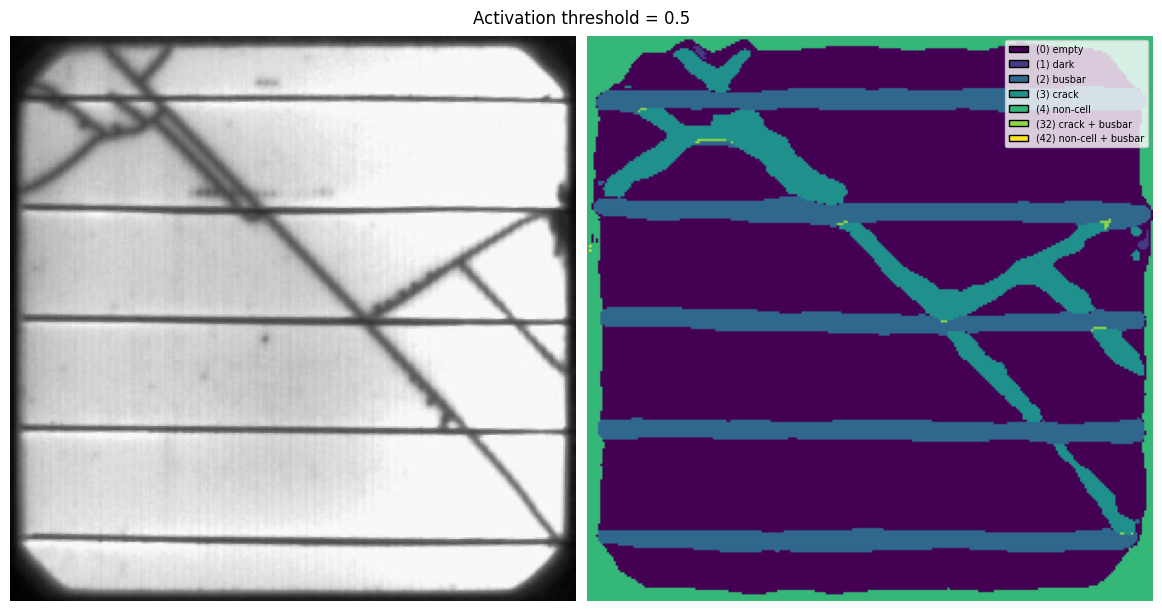

In [15]:
# test_res_chan = retrained_model(img.unsqueeze(0)).detach().cpu().numpy().squeeze()
test_res_chan = model(img.unsqueeze(0)).detach().cpu().numpy().squeeze()

sigmoid = lambda x: 1 / (1 + np.exp(-x))
test_res_act = sigmoid(test_res_chan)

threshold = 0.5
tensor = drop_empty(test_res_act, threshold=threshold)

out = multilabel(tensor, threshold=threshold)
ny, nx = out.shape
x, y = np.arange(nx), np.arange(ny)

category_mapping = {0: "empty", 1: "dark", 2: "busbar", 3: "crack", 4: "non-cell"}

classes = np.unique(out)
print(classes)
cmap = mpl.colormaps["viridis"].resampled(len(classes))
cmaplist = [cmap(i) for i in range(len(classes))]
cmapper = dict((v, c) for v, c in zip(classes, cmaplist))

color_empty = np.zeros((len(x), len(y), 3))

for x, y in itertools.product(x, y):
    color_empty[y, x] = cmapper[out[y, x]][:-1]

fig, ax = plt.subplots(ncols=2, figsize=(12, 6), layout="compressed")


def map_pixels_to_label(val):
    val = int(val)
    if np.isnan(val):
        return val
    elif len(str(val)) == 2:
        return f"({val}) {category_mapping[int(str(val)[0])]} + {category_mapping[int(str(val)[1])]}"
    elif len(str(val)) == 3:
        return f"{category_mapping[int(str(val)[0])]} + {category_mapping[int(str(val)[1])]} + {category_mapping[int(str(val)[2])]}"
    else:
        return f"({val}) {category_mapping[val]}"


im = ax[0].imshow(raw_img.convert("L"), cmap="gray", interpolation="None")
ax[0].axis("off")

# clim = (0,4)
ax[1].imshow(color_empty)  # , clim=clim)

handles, labels = ax[1].get_legend_handles_labels()

for c, classlabel in zip(cmaplist, classes):
    patch = mpatches.Patch(color=c, label=map_pixels_to_label(classlabel), ec="k")
    handles.append(patch)
ax[1].legend(handles=handles, fontsize="x-small")
ax[1].axis("off")
fig.suptitle(f"Activation threshold = {threshold}")

In [9]:
print("Activation value statistics:")
print("Min:", np.min(test_res_act))
print("Max:", np.max(test_res_act))
print("Mean:", np.mean(test_res_act))
print("Standard Deviation:", np.std(test_res_act))

Activation value statistics:
Min: 0.0
Max: 0.9994492
Mean: 0.27890188
Standard Deviation: 0.3019842


In [10]:
for class_idx in range(test_res_act.shape[0]):  # Loop over each category
    print(
        f"Class {class_idx}: {np.sum(test_res_act[class_idx] > 0.45)} pixels above threshold"
    )

Class 0: 43368 pixels above threshold
Class 1: 141 pixels above threshold
Class 2: 11232 pixels above threshold
Class 3: 4920 pixels above threshold
Class 4: 6108 pixels above threshold


[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]


Text(0.5, 0.98, 'Activation threshold = 0.5')

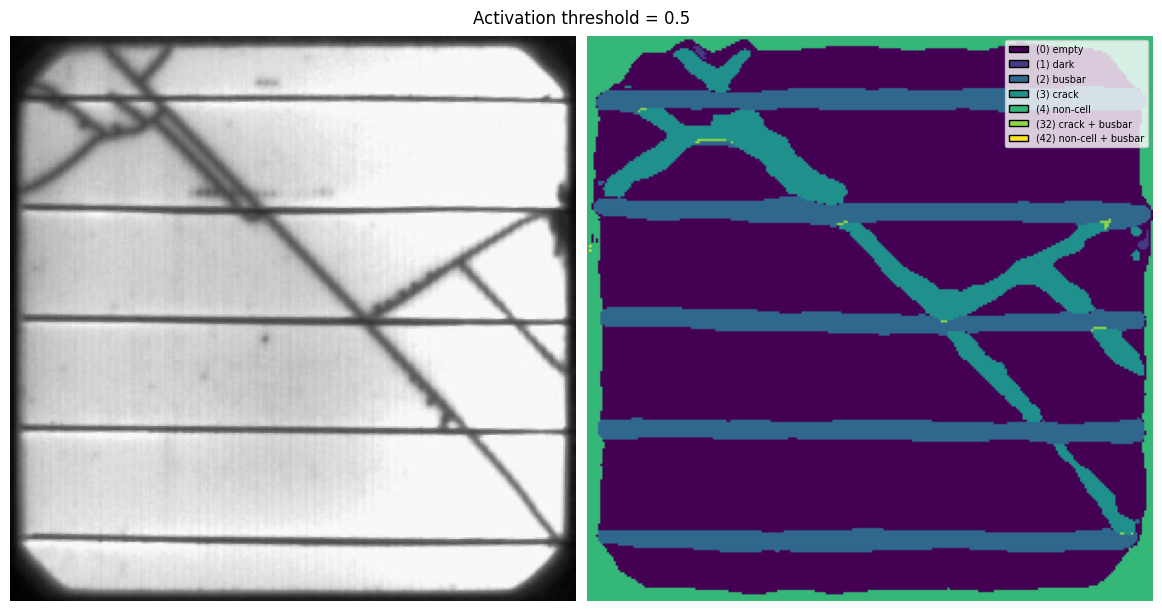

In [11]:
threshold = 0.5
tensor = drop_empty(test_res_act, threshold=threshold)

out = multilabel(tensor, threshold=threshold)
ny, nx = out.shape
x, y = np.arange(nx), np.arange(ny)

category_mapping = {0: "empty", 1: "dark", 2: "busbar", 3: "crack", 4: "non-cell"}

classes = np.unique(out)
print(classes)
cmap = mpl.colormaps["viridis"].resampled(len(classes))
cmaplist = [cmap(i) for i in range(len(classes))]
cmapper = dict((v, c) for v, c in zip(classes, cmaplist))

color_empty = np.zeros((len(x), len(y), 3))

for x, y in itertools.product(x, y):
    color_empty[y, x] = cmapper[out[y, x]][:-1]

fig, ax = plt.subplots(ncols=2, figsize=(12, 6), layout="compressed")


def map_pixels_to_label(val):
    val = int(val)
    if np.isnan(val):
        return val
    elif len(str(val)) == 2:
        return f"({val}) {category_mapping[int(str(val)[0])]} + {category_mapping[int(str(val)[1])]}"
    elif len(str(val)) == 3:
        return f"{category_mapping[int(str(val)[0])]} + {category_mapping[int(str(val)[1])]} + {category_mapping[int(str(val)[2])]}"
    else:
        return f"({val}) {category_mapping[val]}"


im = ax[0].imshow(raw_img.convert("L"), cmap="gray", interpolation="None")
ax[0].axis("off")

# clim = (0,4)
ax[1].imshow(color_empty)  # , clim=clim)

handles, labels = ax[1].get_legend_handles_labels()

for c, classlabel in zip(cmaplist, classes):
    patch = mpatches.Patch(color=c, label=map_pixels_to_label(classlabel), ec="k")
    handles.append(patch)
ax[1].legend(handles=handles, fontsize="x-small")
ax[1].axis("off")
fig.suptitle(f"Activation threshold = {threshold}")